<a href="https://colab.research.google.com/github/theHarshul/RetailDemandPricingForecast/blob/master/HWDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retail Demand Forecasting and Pricing Optimization

**Upload transactions_sampled.csv before running**

In [0]:
pip install catboost==0.16.5

In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb 
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
from google.colab import files

Remove rows with negative quantities and empty values

In [0]:
df = pd.read_csv('transactions_sampled.csv', names = ['id','chain','dept','category','company','brand','date','productsize','productmeasure','productquantity','purchaseamount']) 
df['date']= pd.to_datetime(df['date']) 
quantCols = ['id','chain','dept','category','company','brand', 'productsize','productquantity','purchaseamount']
df[quantCols] = df[df[quantCols] > 0][quantCols]
df = df.dropna()
df = df.reset_index(drop=True)

In [0]:
categorical_features = ['dept','category','company','brand','chain','productmeasure_cat']
features = categorical_features + ['productsize','unitprice','year','month','week']

Create unit price as a feature

In [0]:
# unit price for each trx
df['unitprice'] = df['purchaseamount']/df['productquantity']

Observe product measure categories and respective counts

In [0]:
df.productmeasure.value_counts()

OZ    404681
CT     48734
RL      6243
LB      5638
LT      3714
YD       173
FT         2
1          1
Name: productmeasure, dtype: int64

Remove uncommon and incorrect categories

In [0]:
# remove all uncommon units first
df = df[(df.productmeasure != '1') & (df.productmeasure != 'FT')]

Convert some categories of same measure to common units (lb to oz)

In [0]:
def lb_to_oz(lb):
    return 16 * lb

In [0]:
# convert all product size of lb to oz
df.loc[df['productmeasure'] == 'LB', 'productsize'] = df[(df['productmeasure'] == 'LB')]['productsize'].apply(lb_to_oz)
df[df['productmeasure'] == 'LB']['productmeasure'] = 'OZ'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Lets see if there are any transactions with an outlier number of units purchased

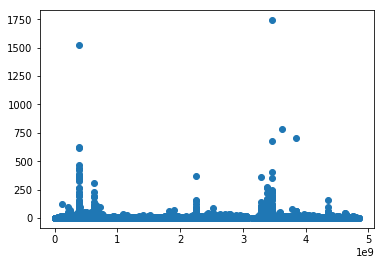

In [0]:
x = df['id']
y = df['productquantity']
plt.scatter(x,y)
plt.show()

*Notice some transactions have more than 1500 units purchased. These are likely errors or may skew our model*

Remove these transactions that are huge outliers in terms of product quantity

In [0]:
df = df[df['productquantity'] < 1500]

In [0]:
# move boundary year dates back one for reconstructing date from week and year in the future
df.loc[df.date == '2012-12-31', 'date'] = datetime.date(2012, 12, 30)

Create seasonal features

In [0]:
# create features year, month, week of trx from date 
df['year'] = df['date'].map(lambda x: x.year)
df['month'] = df['date'].map(lambda x: x.month)
df['week'] = df['date'].map(lambda x: x.week)

Plot Units sold across all products over time

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


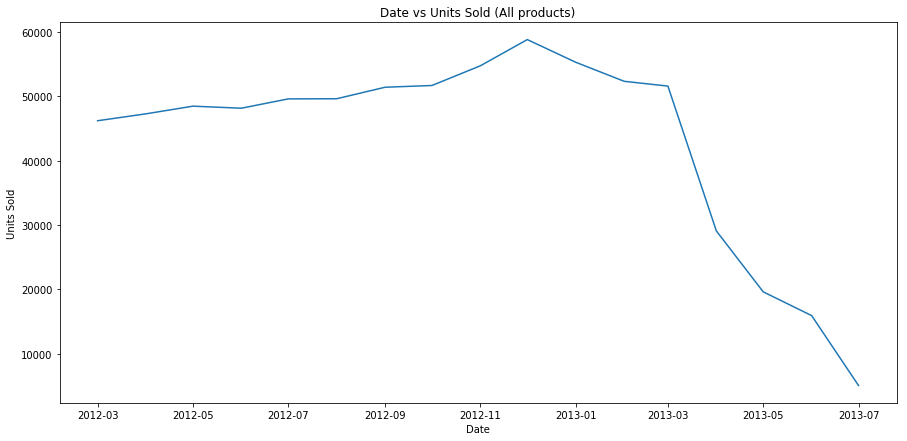

In [0]:
tmp = df
tmp['monthyear'] = tmp['month'].map(str)+ '-' +tmp['year'].map(str)
tmp['monthyear'] = pd.to_datetime(tmp['monthyear'], format='%m-%Y')
tmp = tmp.groupby(["monthyear"]).sum().reset_index()
x = tmp['monthyear']
y = tmp['productquantity']
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(x,y)
plt.title('Date vs Units Sold (All products)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

Plot Demand for Category 6320 split into sizes over time 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


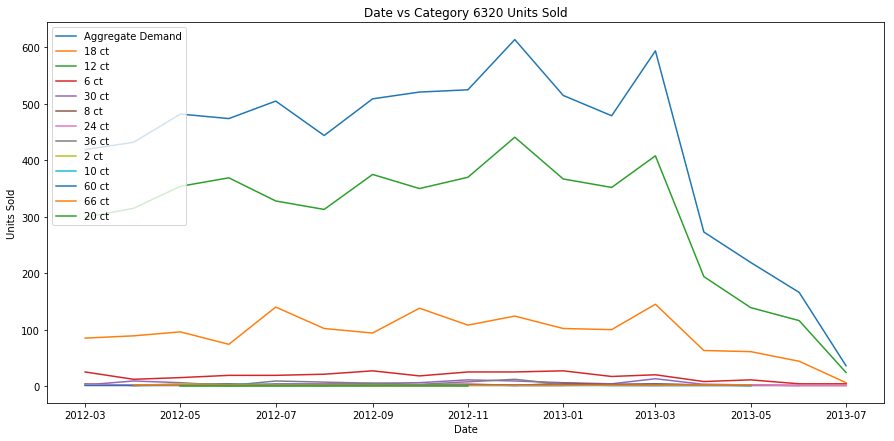

In [0]:
# remove trx outliers as well
tmp = df[(df['category'] == 6320) & (df['productquantity'] < 50)]
tmp['monthyear'] = tmp['month'].map(str)+ '-' +tmp['year'].map(str)
tmp['monthyear'] = pd.to_datetime(tmp['monthyear'], format='%m-%Y')
demand_sizes = tmp.groupby(["monthyear","category","productsize"]).sum().reset_index()
sizes = demand_sizes['productsize'].value_counts().index
tmp = tmp.groupby(["monthyear","category"]).sum().reset_index()
x = tmp['monthyear']
y = tmp['productquantity']
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(x,y,label='Aggregate Demand')
for size in sizes:
  x_size = demand_sizes[demand_sizes['productsize'] == size]['monthyear']
  y_size = demand_sizes[demand_sizes['productsize'] == size]['productquantity']
  plt.plot(x_size,y_size, label=str(int(size)) + ' ct')
plt.legend(loc='upper left')
plt.title('Date vs Category 6320 Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()
#plt.savefig('demand.png')
#files.download('demand.png')

Similar seasonal pattern to the aggregate. Notice the different demand for each size

Plot avg unit price for category 6320 over time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


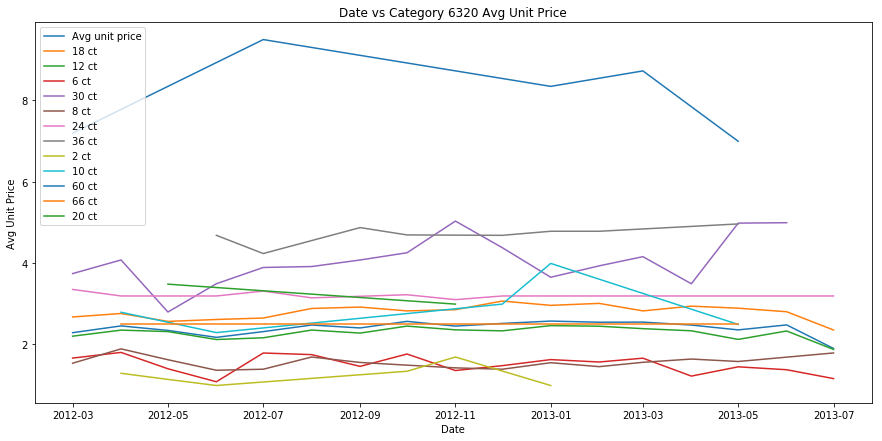

In [0]:
tmp = df[(df['category'] == 6320) & (df['productquantity'] < 50)]
tmp['monthyear'] = tmp['month'].map(str)+ '-' +tmp['year'].map(str)
tmp['monthyear'] = pd.to_datetime(tmp['monthyear'], format='%m-%Y')
demand_sizes = tmp.groupby(["monthyear","category","productsize"]).mean().reset_index()
sizes = demand_sizes['productsize'].value_counts().index
tmp = tmp.groupby(["monthyear","category"]).mean().reset_index()
x = tmp['monthyear']
y = tmp['unitprice']
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(x,y,label ="Avg unit price")
for size in sizes:
  x_size = demand_sizes[demand_sizes['productsize'] == size]['monthyear']
  y_size = demand_sizes[demand_sizes['productsize'] == size]['unitprice']
  plt.plot(x_size,y_size, label=str(int(size)) + ' ct')
plt.legend(loc='upper left')
plt.title('Date vs Category 6320 Avg Unit Price')
plt.xlabel('Date')
plt.ylabel('Avg Unit Price')
plt.show()
#plt.savefig('avgprice.png')
#files.download('avgprice.png')

There are different unit prices, but interestingly size is more important than price to customers. Compare 18 ct and 12 ct vs 2 ct in this graph and the demand graph

In [0]:
df = df.astype({"category": int, "productquantity": int})

Top 50 products over the entire

In [0]:
product_category_agg_df = df.groupby('category').sum()
product_category_agg_df = product_category_agg_df[['productquantity']].sort_values(by=['productquantity'], ascending = False).head(50)
#product_category_agg_df[['productquantity']].sort_values(by=['productquantity'], ascending = False).head(50).to_csv("all_time_demand.csv")
product_category_agg_df
#files.download('all_time_demand.csv')

,productquantity
category,
907,21718
6315,16973
9908,12715
501,12232
9904,9843
5710,9254
902,9005
5705,8498
4107,8424


Top products over the entire dataset broken down by month

In [0]:
product_category_agg_df = df.groupby(['category','month']).sum()
#product_category_agg_df[['productquantity']].sort_values(by=['month','productquantity'], ascending = [True,False]).to_csv("monthly_demand.csv")
product_category_agg_df = product_category_agg_df[['productquantity']].sort_values(by=['month','productquantity'], ascending = [True,False])
product_category_agg_df
#files.download('monthly_demand.csv')

,,productquantity
category,month,
907,1,1434
6315,1,1120
9908,1,980
501,1,936
4107,1,767
2301,1,730
3303,1,702
5710,1,691
902,1,688


Find which date to split the training/test set on using an approximately 80/20 split

In [0]:
dates = list(df.sort_values('date')['date'])
print(dates[4*len(dates)//5])

2013-02-16 00:00:00


Label encode product measure for models like xgboost

In [0]:
df['productmeasure'] = df['productmeasure'].astype('category')
df["productmeasure_cat"] = df["productmeasure"].cat.codes

Lets use 1 day before the 80% mark as the split date for our train and test so that none of the dates overlap and we have enough data for a reasonable test set

In [0]:
df = df.set_index(df['date'])
df = df.sort_index()
train = df[:'2013-02-15']
test = df['2013-02-16':]


## Group categories by a combination of features that we will use for predicting demand

These feature include product level features, pricing, chain, and seasonality

In [0]:
test = test.groupby(['dept','category','company','brand','productsize','productmeasure_cat','chain','year','month','week','unitprice']).sum().drop(columns=['id','purchaseamount']).reset_index()
train = train.groupby(['dept','category','company','brand','productsize','productmeasure_cat','chain','year','month','week','unitprice']).sum().drop(columns=['id','purchaseamount']).reset_index()


This grouping allows us to predict as so - **Given a product of category (men’s shirt), brand (Calvin Klein), product size (medium), and measurement (oz) with some price ($40) at a Chain (San Francisco) on week (15) , month (April), and year (2013), what will be the demand?**

Agter grouping, we will want to create an approximate timestamp from the week and year so that CatBoost can take advantage of the ordering for creating Target Statistics with priors and avoid target leak

In [0]:
def create_timstamp(row):
  date_str = str(int(row['year']) )+ "-W" + str(int(row['week']))
  dt = datetime.datetime.strptime(date_str + '-1', "%Y-W%W-%w")
  return dt

In [0]:
train['datetime'] = train.apply(lambda row: create_timstamp(row), axis=1)
test['datetime'] = test.apply(lambda row: create_timstamp(row), axis=1)

Once we order the sets we can just drop the datetime, Catboost will read them in as ordered

In [0]:
train = train.set_index(train['datetime'])
test = test.set_index(test['datetime'])
train = train.sort_index()
test = test.sort_index()
train = train.reset_index(drop=True).drop(columns =['datetime'])
test = test.reset_index(drop=True).drop(columns =['datetime'])

In [0]:
y_train = train['productquantity'].values
x_train = train.drop(columns=['productquantity']).values

y_test = test['productquantity'].values
x_test = test.drop(columns=['productquantity']).values

# Establish baseline *Naive prediction* - Demand always = Mean



In [0]:
train['productquantity'].mean()
baseline_pred = np.repeat(train['productquantity'].mean(),y_test.shape[0])
rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_pred))
print("Naive RMSE : {}".format(rmse_baseline))


Naive RMSE : 4.206984333498748


# XGBoost

In [0]:
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 10, n_estimators = 100, seed = 8)
xg_reg.fit(x_train,y_train)
xg_pred = xg_reg.predict(x_test)
rmse_xg = np.sqrt(mean_squared_error(y_test, xg_pred))
print("xGBoost RMSE : {}".format(rmse_xg))

xGBoost RMSE : 4.493738645150531


Looks like xGBoost was not able to make sense of the categorical features in a purely numerical format - likely because of high cardinality 

# LightGBM

With categorical_features, light_gbm causes the ram to crash if we go over 30 boosting rounds

In [0]:
lgb_train = lgb.Dataset(x_train, y_train
 ,feature_name = features
 ,categorical_feature = categorical_features
)

params = {
 'task': 'train'
 , 'boosting_type': 'gbdt'
 , 'objective': 'regression'
 , 'metric': 'rmse'
 , 'verbose': 2
 , 'max_depth' : 8
}

lgbm_model = lgb.train(params, lgb_train, num_boost_round=20)
lgbm_pred = lgbm_model.predict(x_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, lgbm_pred))
print("LightGBM RMSE : {}".format(rmse_lgbm))


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LightGBM RMSE : 4.134607697681044


We need a less intensive way of processing high cardinality features. We could use mean encoding, but Catboost is a great option since it creates intelligent target statistics and takes dates into account

Catboost - has_time parameter uses target based statistics looking back at only prior dates for target prediction

In [0]:
categorical_features_indices = [0,1,2,3,5,6]
model=CatBoostRegressor(iterations=150, depth=10, learning_rate=0.1, loss_function='RMSE', random_seed=8, has_time=True)
model.fit(x_train, y_train, cat_features=categorical_features_indices, eval_set=(x_test, y_test),)
pred_cat_boost = model.predict(x_test)

0:	learn: 4.3374833	test: 4.4102101	best: 4.4102101 (0)	total: 205ms	remaining: 30.6s
1:	learn: 4.2657842	test: 4.3533204	best: 4.3533204 (1)	total: 329ms	remaining: 24.3s
2:	learn: 4.2049844	test: 4.3063776	best: 4.3063776 (2)	total: 460ms	remaining: 22.6s
3:	learn: 4.1524080	test: 4.2630355	best: 4.2630355 (3)	total: 583ms	remaining: 21.3s
4:	learn: 4.1072327	test: 4.2323047	best: 4.2323047 (4)	total: 707ms	remaining: 20.5s
5:	learn: 4.0676607	test: 4.2003363	best: 4.2003363 (5)	total: 830ms	remaining: 19.9s
6:	learn: 4.0236341	test: 4.1799059	best: 4.1799059 (6)	total: 957ms	remaining: 19.6s
7:	learn: 3.9860262	test: 4.1559080	best: 4.1559080 (7)	total: 1.08s	remaining: 19.1s
8:	learn: 3.9466104	test: 4.1311330	best: 4.1311330 (8)	total: 1.2s	remaining: 18.8s
9:	learn: 3.9221371	test: 4.1192731	best: 4.1192731 (9)	total: 1.32s	remaining: 18.6s
10:	learn: 3.8968748	test: 4.0987292	best: 4.0987292 (10)	total: 1.45s	remaining: 18.3s
11:	learn: 3.8660095	test: 4.0893854	best: 4.0893854 

# **Gridsearch on Catboost**

In [0]:
optimal_model = CatBoostRegressor()
parameters = {
                  'depth'         : [6,8,10,12],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100, 120],
                  'loss_function' :  ['RMSE'],
                  'random_seed'   : [8],
                  'has_time'      : [True]
             }
grid = GridSearchCV(estimator=optimal_model, param_grid = parameters, cv=[(slice(None), slice(None))], n_jobs=-1)
grid.fit(x_train, y_train)    

    # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      grid.best_estimator_)

print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	learn: 4.3590852	total: 163ms	remaining: 19.4s
1:	learn: 4.2919677	total: 307ms	remaining: 18.1s
2:	learn: 4.2363453	total: 452ms	remaining: 17.6s
3:	learn: 4.1866406	total: 603ms	remaining: 17.5s
4:	learn: 4.1420658	total: 744ms	remaining: 17.1s
5:	learn: 4.1055392	total: 882ms	remaining: 16.8s
6:	learn: 4.0729278	total: 1.02s	remaining: 16.5s
7:	learn: 4.0386564	total: 1.17s	remaining: 16.4s
8:	learn: 4.0120821	total: 1.31s	remaining: 16.1s
9:	learn: 3.9869831	total: 1.45s	remaining: 15.9s
10:	learn: 3.9642108	total: 1.59s	remaining: 15.8s
11:	learn: 3.9368964	total: 1.73s	remaining: 15.6s
12:	learn: 3.9250469	total: 1.88s	remaining: 15.4s
13:	learn: 3.9092540	total: 2.01s	remaining: 15.3s
14:	learn: 3.8912208	total: 2.16s	remaining: 15.1s
15:	learn: 3.8723205	total: 2.29s	remaining: 14.9s
16:	learn: 3.8623049	total: 2.44s	remaining: 14.8s
17:	learn: 3.8480051	total: 2.57s	remaining: 14.6s
18:	learn: 3.8360354	total: 2.71s	remaining: 14.4s
19:	learn: 3.8247268	total: 2.85s	remaini

# Pricing based Revenue Optimization

Find the demand at different price points and use that to maximize revenue

In [0]:
def optimize_revenue(feature_inputs,percent_change, actual_demand, model):
  tmp = feature_inputs.copy()
  updated_price = []
  updated_demand = []
  updated_revenue = []

  for i in range(0,tmp.shape[0]):
    row = tmp[i]
    original_price = row[10]
    original_demand = actual_demand[i]
    original_revenue = original_price * original_demand

    new_price = [(1-change) * (original_price) for change in percent_change]
    new_row = [row.copy()  for _ in range(len(percent_change))]

    for j in range(0,len(new_price)):
      new_row[j][10] = new_price[j]

    new_demand = model.predict(new_row)
    new_revenue = [x*y for x,y in zip(new_price,new_demand)]
    max_revenue = max(new_revenue)
    index_max = new_revenue.index(max_revenue)
    revenue_max_demand = new_demand[index_max]
    
    if max_revenue > original_revenue:
      tmp[i][10] = new_row[index_max][10]
    else:
      max_revenue = original_revenue
      tmp[i][10] = original_price
      revenue_max_demand = original_demand
      
    updated_price.append(tmp[i][10])
    updated_demand.append(revenue_max_demand)
    updated_revenue.append(max_revenue)

  return (updated_price, updated_demand , updated_revenue)


In [0]:
percent_change = [-0.50,-0.25,-0.10,-0.05,0.05,0.10,0.25,0.50]
updated_price, updated_demand , updated_revenue = optimize_revenue(x_test,percent_change, y_test,model)
test['current_revenue'] = test['productquantity'] * test['unitprice']
test['updated_unit_price'] = updated_price
test['updated_demand'] = updated_demand
test['updated_revenue'] = updated_revenue
test

,dept,category,company,brand,productsize,productmeasure_cat,chain,year,month,week,unitprice,productquantity,current_revenue,updated_unit_price,updated_demand,updated_revenue
0,1.0,103,101500010,7142.0,6.00,3,278,2013,2,7,0.750000,2,1.50,0.5625,6.819121,3.835756
1,37.0,3703,105100050,2820.0,10.75,3,26,2013,2,7,1.580000,2,3.16,2.3700,1.677452,3.975560
2,37.0,3703,105100050,2820.0,10.75,3,21,2013,2,7,1.990000,2,3.98,2.9850,1.979787,5.909665
3,37.0,3703,105100050,2820.0,10.75,3,15,2013,2,7,0.720000,2,1.44,1.0800,2.764864,2.986053
4,29.0,2920,101114010,8604.0,15.30,3,89,2013,2,7,2.330000,1,2.33,3.4950,1.264249,4.418551
5,8.0,838,102700020,11091.0,15.00,3,88,2013,2,7,1.000000,5,5.00,1.0000,5.000000,5.000000
6,63.0,6332,104850040,61745.0,59.00,3,96,2013,2,7,3.000000,2,6.00,4.5000,1.383703,6.226662
7,37.0,3703,105100050,2820.0,10.50,3,393,2013,2,7,2.190000,1,2.19,3.2850,1.709690,5.616332
8,8.0,837,101111010,9907.0,12.70,3,211,2013,2,7,2.390000,2,4.78,2.3900,2.000000,4.780000
9,8.0,836,1063403969,12905.0,6.80,3,18,2013,2,7,9.950000,1,9.95,14.9250,1.135903,16.953356


In [0]:
savings = test['updated_revenue'].sum() - test['current_revenue'].sum()
print("Savings: ${}".format(round(savings,2)))
print("{}% of current revenue".format(round(100 + savings/(test['current_revenue'].sum())*100)))

Savings: $256602.59
159.0% of current revenue


The savings are exaggerated because the optimal pricing algorithm takes the best of the markups/discounts and the known original demand- so it will always perform better

Here's a better measure- lets see find what % of the time the pricing algorithm results in more revenue than the current revenue

In [0]:
beatsCurrentPrice = (test[test['updated_revenue'] > test['current_revenue']].shape[0])/(test.shape[0])
print("Pricing algorithm beats current price in terms of revenue {}% of time".format(round(beatsCurrentPrice*100)))

Pricing algorithm beats current price in terms of revenue 85% of time


Download updated demand, pricing, and revenue optimization dataframe

In [0]:
test[['chain','dept','category','company','brand', 'productsize', 'productmeasure_cat', 'year', 'month', 'week', 'unitprice', 'productquantity', 'updated_unit_price', 'updated_demand','current_revenue','updated_revenue']].round(2).to_csv('updated_demand_pricing.csv')
#files.download('updated_demand_pricing.csv')

# Catboost Feature Importance

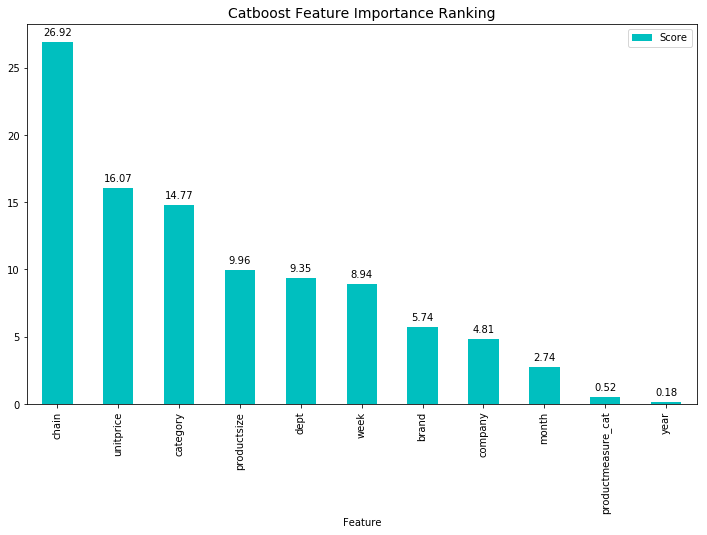

In [0]:
feature_score = pd.DataFrame(list(zip(train.drop(columns=['productquantity']).dtypes.index, model.get_feature_importance(Pool(x_train, label=y_train, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()
